**CMP617**



Objetivo: Gerar um classificador de polaridade utilizando word embeddings e LSTM

#Ambiente

In [ ]:
# Install environment dependencies
%pip install unidecode nltk pandas numpy matplotlib seaborn scikit-learn yellowbrick setuptools plotly gensim==4.3.1 scipy==1.10.1

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

# Datasets

## AmericanasBR

In [ ]:
#baixando os datasets
!curl https://www.inf.ufrgs.br/~viviane/DS/B2W-Reviews01_binario_TEST.csv > B2W-Reviews01_binario_TEST.csv
!curl https://www.inf.ufrgs.br/~viviane/DS/B2W-Reviews01_binario5000_TRAIN.csv > B2W-Reviews01_binario5000_TRAIN.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  981k  100  981k    0     0   214k      0  0:00:04  0:00:04 --:--:--  222k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1657k  100 1657k    0     0   422k      0  0:00:03  0:00:03 --:--:--  422k


In [ ]:
df_train = pd.read_csv('B2W-Reviews01_binario5000_TRAIN.csv')
df_test = pd.read_csv('B2W-Reviews01_binario_TEST.csv')

# Classificação com embeddings

In [ ]:
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.layers import TextVectorization
from keras.layers import Embedding


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epocas")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Pré-processamento

Atividade opcional: verificar resultado com script de pré-processamento do [NILC](http://www.nilc.icmc.usp.br/embeddings).

In [ ]:
import re

In [ ]:
from pandas.core.common import random_state
#função de pré-processamento
special_chars = "¨'!#$%&()*+,-./:;<=>?@[\]^_`{|}~"
# stop_words = stopwords.words('portuguese')
def preprocess(x):
    new_x = x.replace('"',' ')
    for c in special_chars:
        new_x = new_x.replace(c,' ')
    # new_x = ' '.join([word for word in nltk.word_tokenize(new_x.lower(),language='portuguese') if word not in stop_words]) #removendo stop words
    new_x = re.sub(r'[^\w\s]', ' ', new_x) #removendo pontuação do texto
    new_x = re.sub("http\S+", ' ',new_x) # remove links
    new_x = re.sub("@\w+", ' ',new_x) # remove contas com @
    new_x = re.sub('#\S+', ' ',new_x) # hashtags
    new_x = re.sub('[0-9]+', ' ',new_x) # remove numeros e palavras com numeros
    #new_x = unidecode(new_x) #acentos
    new_x = re.sub("\s+", ' ',new_x) # espaços
    new_x = new_x.strip()
    new_x = new_x.lower()
    return new_x

#pré-processar datasets de treino e teste
df_train['text_original'] = df_train['text']
df_train['text'] = df_train['text'].apply(preprocess)

df_test['text_original'] = df_test['text']
df_test['text'] = df_test['text'].apply(preprocess)

df_train = df_train.sample(n=len(df_train), random_state=42).copy()
df_train.reset_index(drop=True, inplace=True)
len(df_train)

10000

In [ ]:
# remove instâncias com texto com comprimento zero ou nulo
df_train = df_train[df_train['text']!='']
df_train = df_train[~df_train['text'].isna()]
df_train.reset_index(drop=True, inplace=True) # reindexa dataframe
len(df_train)

9996

In [ ]:
# remove duplicidades
dup = df_train[df_train.duplicated(subset=['text'])]
df_train = df_train.drop(dup.index)
df_train.reset_index(drop=True, inplace=True) # reindexa dataframe
len(df_train)

9926

## Preparando os datasets


In [ ]:
len(df_train), len(df_test)

(9926, 6000)

In [ ]:
df_train.sample(n=5)

,label,text,label_descr,text_original
8117,1,a distribuição das peças de reposição é muito ...,positivo,A distribuição das peças de reposição é muito ...
5183,1,lojas americanas esta de parabéns entrega supe...,positivo,lojas americanas esta de parabéns entrega supe...
6284,0,o forno não assa de forma homogênea conforme a...,negativo,O forno não assa de forma homogênea conforme a...
7902,0,péssimo fornecedor carente de idoneidade merca...,negativo,"Péssimo fornecedor, carente de idoneidade, Mer..."
5704,1,muito prático e faz bem o que propõe os copos ...,positivo,Muito prático e faz bem o que propõe. Os copos...


Separa treino em treino e validação. O conjunto de validação é ser usado durante treinamento da rede.

In [ ]:
# split treino em: treino e val
train_samples, val_samples, train_labels, val_labels = train_test_split(
    df_train['text'].values, df_train['label'].values, test_size=0.2, random_state=42) #reprodutibilidade dos datasets gerados

test_samples = df_test['text'].values
test_labels = df_test['label'].values

train_samples.shape, val_samples.shape, test_samples.shape

((7940,), (1986,), (6000,))

In [ ]:
train_samples[10], val_samples[10]

('péssimo pedi começo do ano e ainda tá aguardando nota fiscal com previsão de entrega só em abril como uma compradora regular do site estou insatisfeita',
 'lamentavelmente na descrição do produto não informa que precisa utilizar o cabo usb e o vga sendo assim quando comprei o monitor tive que fazer um outro investimento do conversor de vga para hdmi pois meu notebook não tem entrada vga a americanas deveria informar no descritivo do produto essa questão pois o cliente não tem ciência do problema informado acima')

## Criando o codificador para o vocabulário

O `vectorizer` é instanciado usando o `TextVectorization` do Keras que fará a indexação do vocabulario do dataset.

Ou seja, `vectorizer` fará a codificação das instâncias. Aqui o vocabulário considera 20.000 palavras e fará o truncamento ou padding das instâncias para que todas tenham 128 tokens


In [ ]:
MAX_LENGHT = 128
vectorizer = TextVectorization(
    max_tokens=20000, #vocabulário maximo
    output_sequence_length=MAX_LENGHT,
    )

In [ ]:
# antes de adapatar vectorizer a um conjunto de textos o cvocabulario so tem 2 tokens:
len(vectorizer.get_vocabulary()), vectorizer.get_vocabulary()

(2, ['', '[UNK]'])

In [ ]:
# adapapta:
vectorizer.adapt(train_samples)
len(vectorizer.get_vocabulary())

12471

In [ ]:
# agora vemos os tokens do dataset começando pelos mais frequentes:
voc = vectorizer.get_vocabulary()
print(f'Vocabulário tem {len(voc)} tokens. Os primeiros 10 tokens são:')
voc[:100]

Vocabulário tem 12471 tokens. Os primeiros 10 tokens são:


['',
 '[UNK]',
 np.str_('o'),
 np.str_('e'),
 np.str_('a'),
 np.str_('de'),
 np.str_('não'),
 np.str_('produto'),
 np.str_('que'),
 np.str_('muito'),
 np.str_('é'),
 np.str_('com'),
 np.str_('do'),
 np.str_('um'),
 np.str_('para'),
 np.str_('da'),
 np.str_('em'),
 np.str_('no'),
 np.str_('entrega'),
 np.str_('recomendo'),
 np.str_('mais'),
 np.str_('uma'),
 np.str_('na'),
 np.str_('bom'),
 np.str_('mas'),
 np.str_('chegou'),
 np.str_('foi'),
 np.str_('se'),
 np.str_('comprei'),
 np.str_('eu'),
 np.str_('qualidade'),
 np.str_('as'),
 np.str_('americanas'),
 np.str_('prazo'),
 np.str_('recebi'),
 np.str_('ainda'),
 np.str_('bem'),
 np.str_('me'),
 np.str_('já'),
 np.str_('tem'),
 np.str_('por'),
 np.str_('como'),
 np.str_('meu'),
 np.str_('estou'),
 np.str_('excelente'),
 np.str_('até'),
 np.str_('os'),
 np.str_('antes'),
 np.str_('compra'),
 np.str_('veio'),
 np.str_('pra'),
 np.str_('minha'),
 np.str_('super'),
 np.str_('sem'),
 np.str_('só'),
 np.str_('pois'),
 np.str_('ótimo'),
 np.s

Vetorizando uma sentença:

In [ ]:
output = vectorizer([["chuva forte na floresta"]])
output.shape, output

(TensorShape([1, 128]),
 <tf.Tensor: shape=(1, 128), dtype=int64, numpy=
 array([[2267,  691,   22,    1,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0]])>)

In [ ]:
# conferindo as palavras que correnspodem a alguns dos índices gerados na condificação:
voc[2267],voc[691], voc[22], voc[1]

(np.str_('chuva'), np.str_('forte'), np.str_('na'), '[UNK]')

In [ ]:
# um dicionario com todas as palavras do vocabulario e seus indices de 0 a len(voc)-1
word_index = dict(zip(voc, range(len(voc))))
len(voc)

12471

In [ ]:
word_index['chuva']

2267

## Usando embeddings pré-treinadas
####Há várias opções de embeddings já treinadas em português no site do NILC nesse [link](http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc)

In [ ]:
#Opção 1: baixando as embeddings do NILC
# !curl http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s100.zip > glove_s100.zip
# !unzip -o glove_s100.zip

!curl http://143.107.183.175:22980/download.php?file=embeddings/fasttext/skip_s100.zip > skip_s100.zip
!unzip -o skip_s100.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  299M  100  299M    0     0  10.4M      0  0:00:28  0:00:28 --:--:-- 11.2M
Archive:  skip_s100.zip
  inflating: skip_s100.txt           


In [ ]:
#embFile = 'fast_cbow_s50.txt'
#embFile = 'fast_skip_s100.txt'
embFile = 'skip_s100.txt'
#embFile = 'w2v_skip_s300.txt'
# embFile = 'glove_s100.txt'
embedding_dim = 100


In [ ]:
#Opção 2 para quem tem as embeddings no seu drive
# from google.colab import drive
# drive.mount('/content/drive')
# embFile = f"/content/drive/MyDrive/Colab Notebooks/embeddings/{embFile}"

In [ ]:
# verificando o arquivo de embeddings e carregando para uma matriz: cada linha da matriz tem o numero de dimensões das embeddings
embeddings_index = {}
with open(embFile) as f:
    l=0
    for line in f:
        if l>0:
            pos = line.find(' ')
            word = line[0:pos]
            vector = line[pos:len(line)]
            vector = vector.replace('\n','')
            vector = vector.strip()
            vector = list(map(float, vector.split(' ')))
            embeddings_index[word] = vector
        l += 1
print(f"Encontrados {len(embeddings_index)} vetores de palavras.")

Encontrados 929605 vetores de palavras.


Verificando palavras do arquivo de embeddings:

In [ ]:
primeira = list(embeddings_index.keys())[0]
print('primeiro token: ',primeira)
print('embeddigns do primeiro token: ',embeddings_index[primeira])
print('---------------')
centesima = list(embeddings_index.keys())[100]
print('centésimo token: ',centesima)
print('embeddigns do centesimo token: ',embeddings_index[centesima])
print('---------------')
ultima = list(embeddings_index.keys())[len(embeddings_index)-1]
print('ultimo token: ',ultima)
print('embeddigns do ultimo token: ',embeddings_index[ultima])


primeiro token:  ,
embeddigns do primeiro token:  [0.19787, 0.040916, 0.0082059, -0.15349, -0.24492, -0.055641, -0.17153, -0.04697, 0.20225, -0.079832, 0.089199, 0.039603, -0.09521, -0.0095435, 0.039155, -0.23808, -0.40891, 0.097563, -0.12359, -0.12023, -0.13557, 0.0041987, 0.12311, 0.045338, 0.00015713, -0.14143, -0.1923, 0.11139, 0.15076, 0.079623, 0.27701, 0.1229, -0.16766, -0.13915, -0.30957, -0.086924, 0.25666, -0.24716, -0.35433, 0.32706, -0.21388, -0.16521, 0.047764, -0.14421, -0.27477, 0.16616, 0.089759, 0.34937, -0.11097, 0.061492, -0.069643, 0.44458, -0.073322, -0.1286, 0.015, 0.29297, -0.42703, 0.17069, 0.22864, 0.16299, 0.21503, -0.03303, 0.011901, 0.20363, 0.3327, -0.23554, -0.11752, -0.18648, 0.067902, -0.033799, 0.0095426, 0.024427, 0.37478, 0.19837, -0.19143, -0.012367, 0.4497, -0.16549, 0.26319, 0.018696, 0.020859, -0.1106, 0.017879, -0.2289, -0.27333, 0.022579, 0.14598, -0.12368, -0.011224, -0.43002, -0.023896, 0.30938, -0.23384, 0.094746, -0.3298, 0.31299, -0.065709,

In [ ]:
len(word_index), len(voc),len(embeddings_index)

(12471, 12471, 929605)

In [ ]:
word_index['mais']

20

O proximo passo é efetuar o mapeamento entre as embeddings e as palavras do vocabulário do dataset. Prepara-se uma matriz de embeddings: uma matriz NumPy simples onde a entrada no índice `i` é o vetor pré-treinado para a palavra de índice `i` no vocabulário do nosso `vetorizador`.

In [ ]:
embedding_dim

100

In [ ]:
num_tokens = len(voc)
hits = 0
misses = 0

# Preparando  a matriz de embeddings
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in embeddings_index:
        # print(word, i, len(embeddings_index[word]))
        # Palavras não encontradas no índice de embeddings terão seus valores na matriz zerados
        embedding_matrix[i] = embeddings_index[word]
        hits += 1
    else:
        misses += 1
print(f"Mapeadas {hits} palavras e {misses} não existem nas embeddings (OOV))")


Mapeadas 11497 palavras e 974 não existem nas embeddings (OOV))


In [ ]:
# Tamanho da matrix de embeddings e do vocabulario:
embedding_matrix.shape, len(vectorizer.get_vocabulary())

((12471, 100), 12471)

## Preparando o modelo

### Embedding layer

A matriz `embedding_matrix` é usada na definição do layer de embeddings.

In [ ]:
num_tokens, embedding_dim, embedding_matrix.shape

(12471, 100, (12471, 100))

In [ ]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False, #mantem o layer de embeddgins com os valores que está e nao treina isso junto coma  rede
)
embedding_layer.build((1,))
#usa os pesos das embeddings
embedding_layer.set_weights([embedding_matrix])

Atividade opcional: treinar as embeddgins do dataset (por exemplo usando gensim, ou usando a propria rede).

### LSTM

In [ ]:
import numpy as np
import keras
from keras import layers


In [ ]:
#configura um vetor de inputs que tera os identificadores do vocabulario
inputs = keras.Input(shape=(None,), dtype="int32")

# converte as embeddgins de cada input
embedded_sequences = embedding_layer(inputs)

# adiciona uma LSTM bidirecional
x = layers.Bidirectional(layers.LSTM(64))(embedded_sequences)

# adiciona um classificador binário
outputs = layers.Dense(1, activation="sigmoid")(x)

# Cria o modelo
model = keras.Model(inputs, outputs)

#Exibe o resumo do modelo e suas camadas
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 100)           │       1,247,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,331,709 (5.08 MB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 1,247,100 (4.76 MB)

Estamos usando `binary_crossentropy` como loss para a classificação binária.

[`Adam`](https://keras.io/api/optimizers/adam/) é o otimizador usado com `learning_rate` default de 0.001.

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

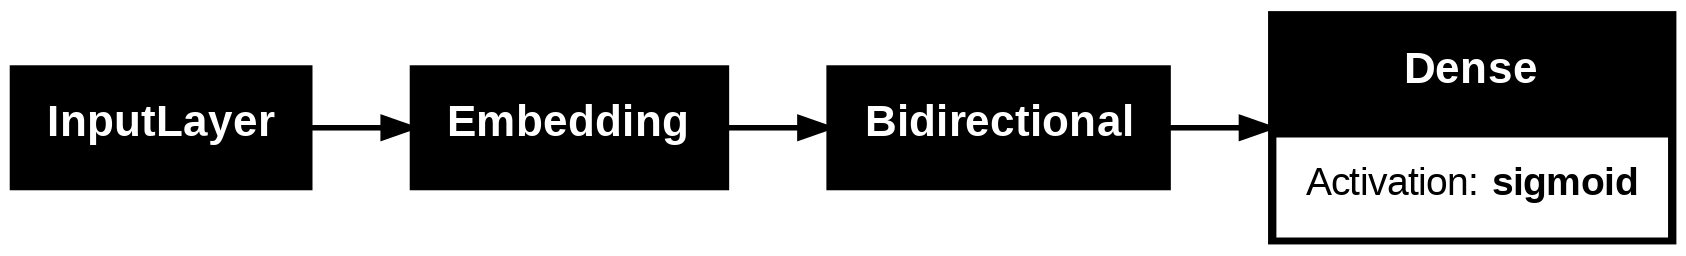

In [ ]:
keras.utils.plot_model(model, show_layer_names=False, rankdir='LR', show_layer_activations=True)

## Treinando o modelo

Convertendo o texto dos 3 datasets (treino, val e teste) em vetores com índices do vocabulário, usando o vetorizador definido anteriormente.

In [ ]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

x_train.shape, x_val.shape, x_test.shape

((7940, 128), (1986, 128), (6000, 128))

In [ ]:
i=10
train_samples[i], x_train[i]

('péssimo pedi começo do ano e ainda tá aguardando nota fiscal com previsão de entrega só em abril como uma compradora regular do site estou insatisfeita',
 array([ 121,  307, 1630,   12,  368,    3,   35,  622,  228,  164,  354,
          11,  489,    5,   18,   54,   16, 1116,   41,   21, 4166, 1278,
          12,   73,   43,  584,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0

In [ ]:
class_names = df_train.label_descr.unique()
class_names

array(['positivo', 'negativo'], dtype=object)

In [ ]:
%%time
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7392 - loss: 0.5344 - val_accuracy: 0.8580 - val_loss: 0.3418
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8386 - loss: 0.3746 - val_accuracy: 0.8781 - val_loss: 0.3136
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8741 - loss: 0.3117 - val_accuracy: 0.8847 - val_loss: 0.2858
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8881 - loss: 0.2723 - val_accuracy: 0.8988 - val_loss: 0.2689
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8899 - loss: 0.2658 - val_accuracy: 0.8867 - val_loss: 0.2825
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9049 - loss: 0.2333 - val_accuracy: 0.9018 - val_loss: 0.2532
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9164 - loss: 0.2120 - val_accuracy: 0.9109 - val_loss: 0.2319
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9166 - loss: 0.2144 - val_accu

(0.8019080758094788, 1.0)

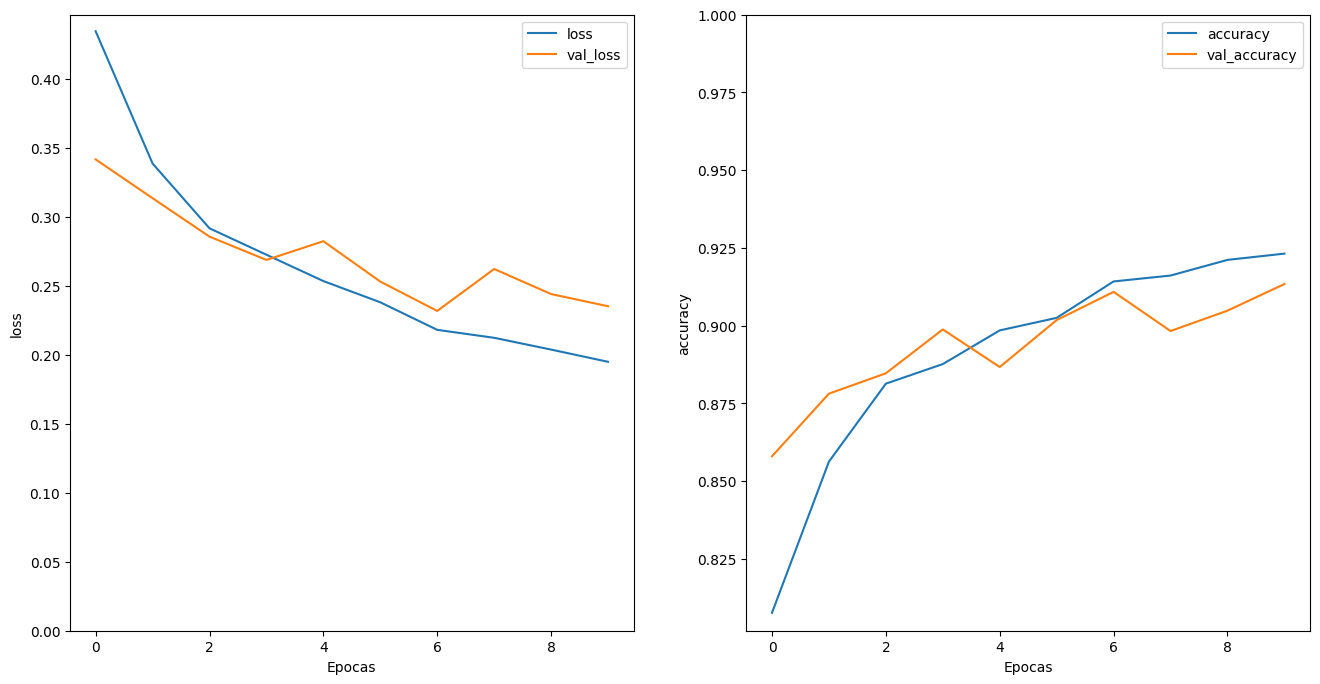

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.subplot(1, 2, 2)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)


## Avaliando a Qualidade do Modelo


A função `model.evaluate` prevê a saída para a entrada fornecida e, em seguida, calcula a função de métricas especificadas em `model.compile` com base em `y_true` e `y_pred`.

O `model.predict` apenas retorna o y_pred, mas ao final devem chegar no mesmo valor.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
df_test.sample(n=5)

,label,text,label_descr,text_original
1507,1,muito boa fácil instalação e configuração imag...,positivo,"Muito boa, fácil instalação e configuração. Im..."
5641,0,pedi tamnho g e veio tamanho m fica apertado e...,negativo,"Pedi tamnho G e veio tamanho m, fica apertado ..."
3220,0,a pedra do anel já caiu o anel foi dado com me...,negativo,"A pedra do anel já caiu , o anel foi dado com ..."
176,1,é do tamanho de uma cafeteira será muito prati...,positivo,"É do tamanho de uma cafeteira, será muito prat..."
4991,0,não gostei se é bonita mais o material e muito...,negativo,Não gostei se é bonita mais o material e muito...


In [ ]:
i=10
train_samples[i], x_train[i]

('péssimo pedi começo do ano e ainda tá aguardando nota fiscal com previsão de entrega só em abril como uma compradora regular do site estou insatisfeita',
 array([ 121,  307, 1630,   12,  368,    3,   35,  622,  228,  164,  354,
          11,  489,    5,   18,   54,   16, 1116,   41,   21, 4166, 1278,
          12,   73,   43,  584,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = False)
print(f'Test Loss: {test_loss:.5f}')
print(f'Test Accuracy: {test_acc:.5f}')

Test Loss: 0.21954
Test Accuracy: 0.91450


In [ ]:
y_prob = model.predict(np.array(x_test))
# convertendo o vetor de probabilidads em um vetor de predições binárias
# y_pred = [int(i > .5) for i in y_prob]
y_pred = [int(i > .5) for i in y_prob.flatten()]
print(f"Acurácia: {accuracy_score(y_test, y_pred):.5f}")
y_pred[0:15]


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Acurácia: 0.91450


[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]

Acurácia: 0.91450
F1-macro: 0.91449


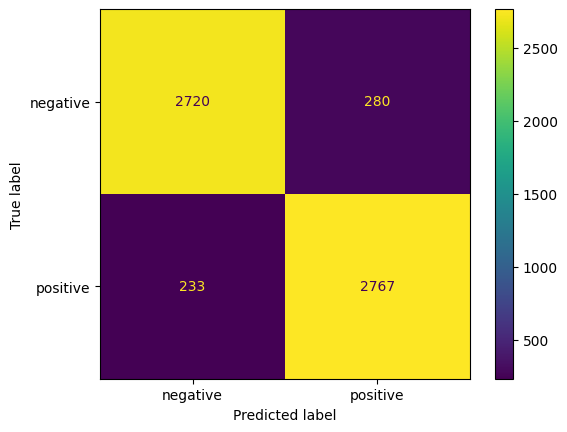

In [ ]:
#matriz de confusão
print(f"Acurácia: {accuracy_score(y_test, y_pred):.5f}")
print(f"F1-macro: {f1_score(y_test, y_pred, average='macro'):.5f}")
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['negative','positive'])
cm_display.plot()
plt.show()

##Examinando as instâncias mal classificadas

In [ ]:
erros  = list (zip(df_test['text'].values,df_test['text_original'].values,y_test,y_pred)) #criando lista com os erros
erros = [item for item in erros if item[2] != item[3]] #removendo as instâncias corretas
df_erros = pd.DataFrame(erros,columns =['Texto','Original','True','Pred']) #gerando um dataframe para ficar mais fácil de trabalhar

In [ ]:
#acrescentando colunas FP e FN no dataframe com os erros
df_erros['FP'] = df_erros.apply(lambda x: 1 if ((x['Pred']==1) & (x['True']==0)) else 0, axis=1)
df_erros['FN'] = df_erros.apply(lambda x: 1 if ((x['Pred']==0) & (x['True']==1)) else 0, axis=1)

In [ ]:
print('Há ', len(df_erros),' instâncias mal classificadas.')

Há  513  instâncias mal classificadas.


In [ ]:
#inspecionando os falsos negativos
df_erros[df_erros['FN']==1]

,Texto,Original,True,Pred,FP,FN
0,chegou antes do prazo a caneta é fininha e nao...,"Chegou antes do prazo, a caneta é fininha e na...",1,0,0,1
1,comprei entrega a jato para entregar em dia út...,Comprei entrega a jato para entregar em 1 dia ...,1,0,0,1
2,não liguem para o valor o material é de outro ...,"Não liguem para o valor, o material é de outro...",1,0,0,1
3,o produto foi leal aquilo que o marketing anun...,O produto foi leal aquilo que o marketing anun...,1,0,0,1
4,acho extranho a americana vender este aparelho...,acHo extranho a AMERICANA VENDER ESTE APARELHO...,1,0,0,1
...,...,...,...,...,...,...
228,relógio bonito todo preto mas não é robusto qu...,"Relógio bonito, todo preto, mas não é robusto ...",1,0,0,1
229,bem legal o celular tela grande bateria dura m...,"Bem legal o celular, tela grande, bateria du...",1,0,0,1
230,cumpre o que promete apesar de aparência frági...,"Cumpre o que promete, apesar de aparência frág...",1,0,0,1
231,apesar da nvi não ser a minha tradução preferi...,Apesar da NVI não ser a minha tradução preferi...,1,0,0,1


In [ ]:
#inspecionando os falsos positivos
df_erros[df_erros['FP']==1]

,Texto,Original,True,Pred,FP,FN
198,a entrega foi super rápida mas o produto desli...,"A entrega foi super rápida, mas o produto desl...",0,1,1,0
199,o produto comprado deu problema no touch scree...,O produto comprado deu problema no touch scree...,0,1,1,0
200,muito frágil de operação difícil não recomendo,Muito frágil de operação difícil. Não recomend...,0,1,1,0
201,o tamanho não confere com o da descrição não c...,"O tamanho não confere com o da descrição, não...",0,1,1,0
202,boa tarde a mercadoria veio faltando peças par...,"boa tarde,a mercadoria veio faltando peças par...",0,1,1,0
...,...,...,...,...,...,...
550,na fotografia parece um equipamento bom mas é ...,"Na fotografia parece um equipamento bom, mas é...",0,1,1,0
551,quanto ao vendedor muito bom pontual tudo cert...,"Quanto ao vendedor, muito bom, pontual , tudo ...",0,1,1,0
552,ja tem mais de dias e nada do meu produto chegar,ja tem mais de 30 dias e nada do meu produto c...,0,1,1,0
553,não aprovei o produto pelas questões da qualid...,Não aprovei o produto pelas questões da qualid...,0,1,1,0


# Persistência

Para persistencia do modelo e utilizar o mesmo sem precisar retreinar:

https://www.tensorflow.org/guide/keras/save_and_serialize